# **BirdCLEF 2025 Data Preprocessing Notebook**
This notebook demonstrates how we can transform audio data into mel-spectrogram data. This transformation is essential for training 2D Convolutional Neural Networks (CNNs) on audio data, as it converts the one-dimensional audio signals into two-dimensional image-like representations.
I run this public notebook in debug mode(only a few sample processing). You can find the fully preprocessed mel spectrogram training dataset here --> [BirdCLEF'25 | Mel Spectrograms](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms).


In [1]:
import os
import cv2
import math
import time
import librosa
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
class Config:
 
    DEBUG_MODE = False
    
    OUTPUT_DIR = '/kaggle/working/'
    DATA_ROOT = '/kaggle/input/birdclef-2025'
    FS = 32000
    
    # Mel spectrogram parameters
    N_FFT = 2048
    HOP_LENGTH = 128
    N_MELS = 128
    FMIN = 50
    FMAX = 16000
    
    TARGET_DURATION = 5.0
    TARGET_SHAPE = (256, 256)
    
    N_MAX = 4 if DEBUG_MODE else None

    PCEN = False
    MU_EXPAND = True
    MU_EXPAND_PASS = 1
    MU_EXPAND_MU = 255.0

    CLIPPING = False
    LOW_CLIP = 10
    HIGH_CLIP = 99.6

config = Config()

In [3]:
print(f"Debug mode: {'ON' if config.DEBUG_MODE else 'OFF'}")
print(f"Max samples to process: {config.N_MAX if config.N_MAX is not None else 'ALL'}")

print("Loading taxonomy data...")
taxonomy_df = pd.read_csv(f'{config.DATA_ROOT}/taxonomy.csv')
species_class_map = dict(zip(taxonomy_df['primary_label'], taxonomy_df['class_name']))

print("Loading training metadata...")
train_df = pd.read_csv(f'{config.DATA_ROOT}/train.csv')

print("Loading voice sammury data...")
with open("/kaggle/input/bc25-separation-voice-from-data-by-silero-vad/train_voice_summary.txt") as f:
    voice_audio_list = f.read().split("\n")

print("Loading voice data...")
with open("/kaggle/input/bc25-separation-voice-from-data-by-silero-vad/train_voice_data.pkl", "rb") as f:
    voice_data = pickle.load(f)

Debug mode: OFF
Max samples to process: ALL
Loading taxonomy data...
Loading training metadata...
Loading voice sammury data...
Loading voice data...


In [4]:
label_list = sorted(train_df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

print(f'Found {len(label_list)} unique species')
working_df = train_df[['primary_label', 'rating', 'filename']].copy()
working_df['target'] = working_df.primary_label.map(label2id)
working_df['filepath'] = config.DATA_ROOT + '/train_audio/' + working_df.filename
working_df['samplename'] = working_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
working_df['class'] = working_df.primary_label.map(lambda x: species_class_map.get(x, 'Unknown'))
total_samples = min(len(working_df), config.N_MAX or len(working_df))
print(f'Total samples to process: {total_samples} out of {len(working_df)} available')
print(f'Samples by class:')
print(working_df['class'].value_counts())

Found 206 unique species
Total samples to process: 28564 out of 28564 available
Samples by class:
class
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


In [5]:
def audio2melspec(audio_data, config):
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    if config.MU_EXPAND:
        audio_data = np.clip(audio_data, -1, 1)
        for i in range(config.MU_EXPAND_PASS):
            audio_data = librosa.mu_expand(audio_data,mu=config.MU_EXPAND_MU,quantize=False)
    
    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=config.FS,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS,
        fmin=config.FMIN,
        fmax=config.FMAX,
        power=1.0,
        # norm='slaney',
        # htk=True,
    )

    if config.PCEN:
        pcen_S = librosa.pcen(
            mel_spec * (2**31),
            sr=config.FS,
            hop_length=128,
            time_constant=0.06,
            bias=10,
            gain=0.8,
            power=0.25
        )
        pcen_norm = (pcen_S - pcen_S.min()) / (pcen_S.max() - pcen_S.min() + 1e-8)
        return pcen_norm
    else:
        mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
        # Hard clipping the extreme black & white values
        if config.CLIPPING:
            p_low, p_high = np.percentile(mel_spec_db, (config.LOW_CLIP, config.HIGH_CLIP))
        else:
            p_low = mel_spec_db.min()
            p_high = mel_spec_db.max()
        mel_spec_norm = (mel_spec_db - p_low) / (p_high - p_low + 1e-8)
        return mel_spec_norm


In [6]:
def remove_voice(audio_data, voice_segment, config):
    # 無音区間のリストを作成
    non_voice_segments = []
    prev_end = 0

    for st in voice_segment:
        start, end = math.floor(st["start"] * config.FS), math.ceil(st["end"] * config.FS)
        if prev_end < start:
            non_voice_segments.append((prev_end, start))
        prev_end = max(prev_end, end)

    if prev_end < len(audio_data):
        non_voice_segments.append((prev_end, len(audio_data)))

    # 最も長い区間を見つける
    longest_segment = None
    max_duration = 0
    for start, end in non_voice_segments:
        segment = audio_data[start:end]
        if len(segment) > max_duration:
            max_duration = len(segment)
            longest_segment = segment
    return longest_segment

In [7]:
print("Starting audio processing...")
print(f"{'DEBUG MODE - Processing only 50 samples' if config.DEBUG_MODE else 'FULL MODE - Processing all samples'}")
start_time = time.time()

print(voice_audio_list[:10])

all_bird_data = {}
errors = []

for i, row in tqdm(working_df.iterrows(), total=total_samples):
    if config.N_MAX is not None and i >= config.N_MAX:
        break
    
    try:
        # 音声のロード
        audio_data, _ = librosa.load(row.filepath, sr=config.FS)

        # 人の声が入っている音声の場合...
        if row.filepath in voice_audio_list:
            # 人の声を削除したうえで一番長い部分を取得
            print(f"{row.filepath}から発話を削除")
            voice_segment = voice_data[row.filepath]
            audio_data = remove_voice(audio_data, voice_segment, config)

        target_samples = int(config.TARGET_DURATION * config.FS)

        if len(audio_data) < target_samples:
            n_copy = math.ceil(target_samples * 2 / len(audio_data))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        trim_start = max(0, int(len(audio_data) * 0.1));
        trim_end = min(len(audio_data), int(len(audio_data) - trim_start))
        audio_data = audio_data[trim_start:trim_end]
        rms = librosa.feature.rms(y=audio_data)
        max_rms_pos = (np.argmax(rms)) * 512
        # start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
        start_idx = max(0, int(max_rms_pos - target_samples / 2))
        end_idx = min(len(audio_data), start_idx + target_samples)
        center_audio = audio_data[start_idx:end_idx]
        #print(len(audio_data), rms.shape, max_rms_pos, start_idx, end_idx)

        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, 
                                 (0, target_samples - len(center_audio)), 
                                 mode='reflect')

        mel_spec = audio2melspec(center_audio, config)

        if mel_spec.shape != config.TARGET_SHAPE:
            if config.DEBUG_MODE:
                print(mel_spec.shape)
                print("resizing")
            mel_spec = cv2.resize(mel_spec, config.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)
        '''
        blur = cv2.GaussianBlur(mel_spec, (0, 0), 3)
        mel_spec = cv2.addWeighted(mel_spec, 1.5, blur, -1.0, 0)
        mel_spec = cv2.subtract(mel_spec, 0.1)
        mel_spec_norm = np.zeros(config.TARGET_SHAPE)
        mel_spec_norm = cv2.normalize(mel_spec, mel_spec_norm, alpha=1.0, beta=0.0, norm_type=cv2.NORM_MINMAX)
        all_bird_data[row.samplename] = mel_spec_norm.astype(np.float32)
        '''
        all_bird_data[row.samplename] = mel_spec.astype(np.float32)

    except Exception as e:
        print(f"Error processing {row.filepath}: {e}")
        errors.append((row.filepath, str(e)))

np.save(config.OUTPUT_DIR + "birdclef2025_melspec_without_voice_per5sec_256_256.npy", all_bird_data, allow_pickle=True)

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds")
print(f"Successfully processed {len(all_bird_data)} files out of {total_samples} total")
print(f"Failed to process {len(errors)} files")

Starting audio processing...
FULL MODE - Processing all samples
['/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.ogg', '/kaggle/input/birdclef-2025/train_audio/1139490/CSA36389.ogg', '/kaggle/input/birdclef-2025/train_audio/1192948/CSA36358.ogg', '/kaggle/input/birdclef-2025/train_audio/1192948/CSA36366.ogg', '/kaggle/input/birdclef-2025/train_audio/1192948/CSA36373.ogg', '/kaggle/input/birdclef-2025/train_audio/1192948/CSA36388.ogg', '/kaggle/input/birdclef-2025/train_audio/1194042/CSA18783.ogg', '/kaggle/input/birdclef-2025/train_audio/1194042/CSA18794.ogg', '/kaggle/input/birdclef-2025/train_audio/1194042/CSA18802.ogg', '/kaggle/input/birdclef-2025/train_audio/126247/iNat146584.ogg']


  0%|          | 0/28564 [00:00<?, ?it/s]

/kaggle/input/birdclef-2025/train_audio/1139490/CSA36385.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1139490/CSA36389.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1192948/CSA36358.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1192948/CSA36366.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1192948/CSA36373.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1192948/CSA36388.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1194042/CSA18783.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1194042/CSA18794.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1194042/CSA18802.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/126247/iNat146584.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1346504/CSA18784.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1346504/CSA18791.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1346504/CSA18792.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1346504/CSA18793.oggから発話を削除
/kaggle/input/birdclef-2025/train_audio/1346504

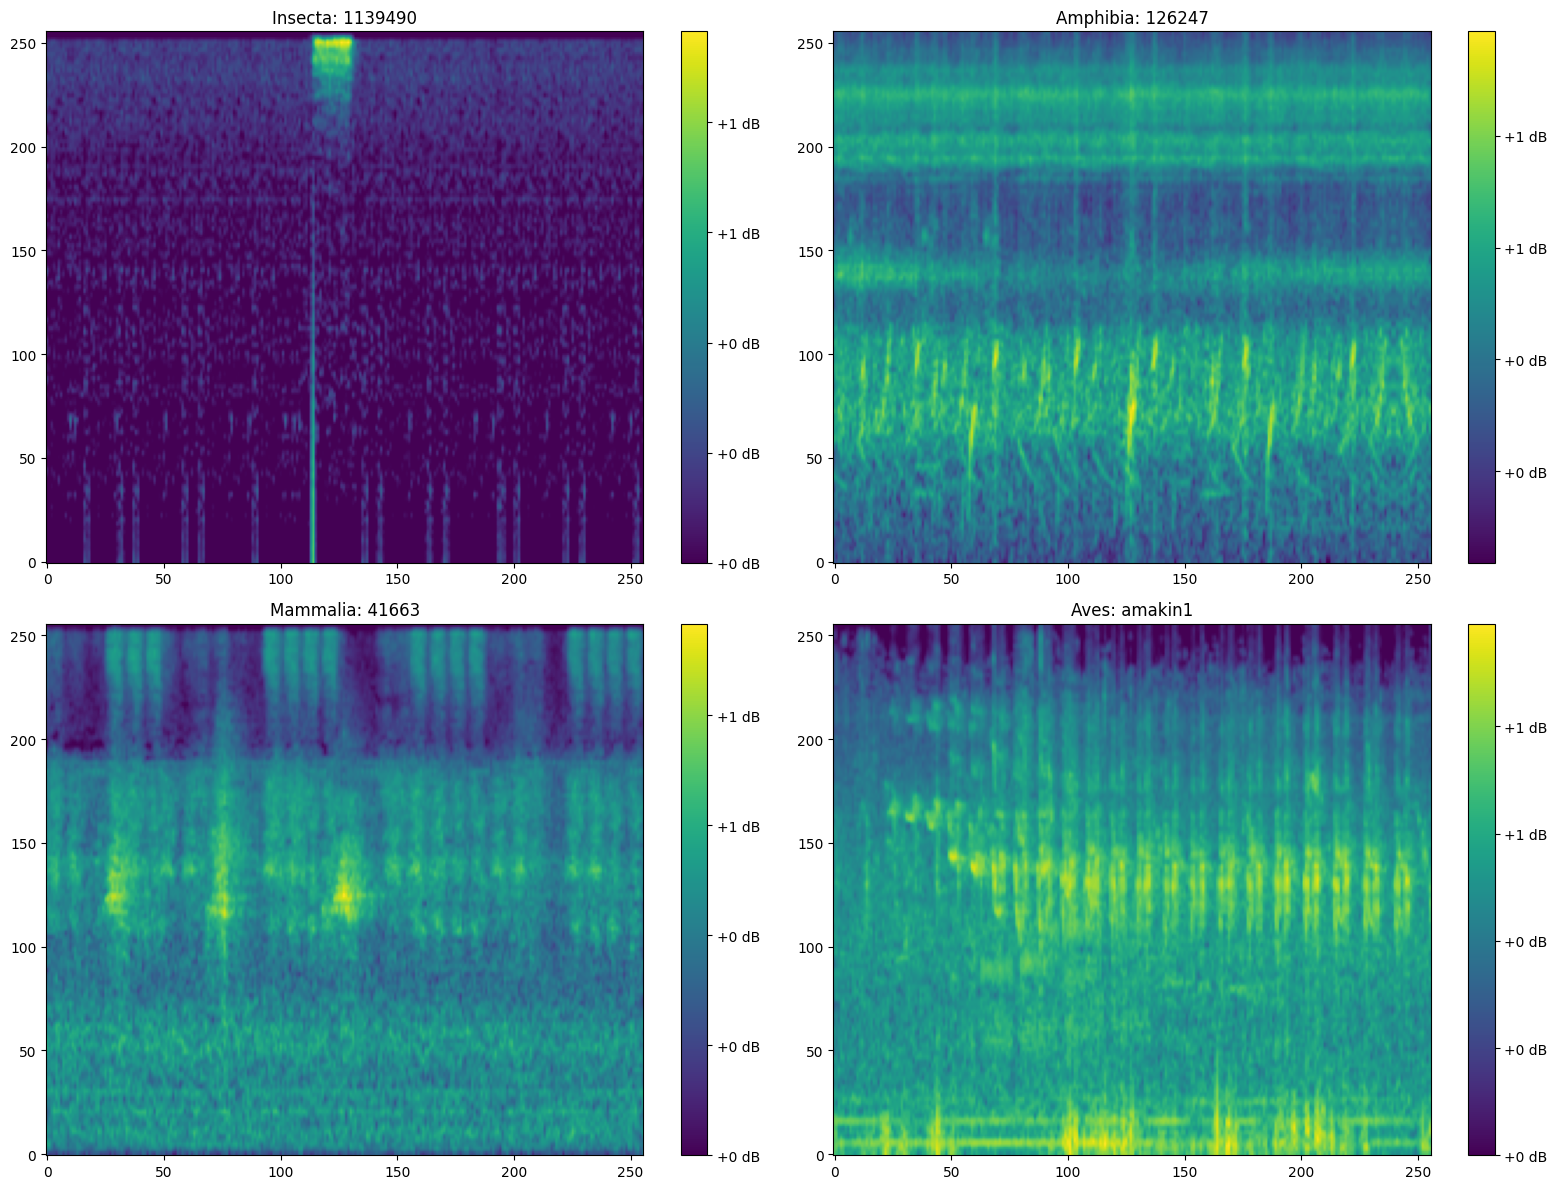

In [8]:
import matplotlib.pyplot as plt

samples = []
displayed_classes = set()

max_samples = min(4, len(all_bird_data))

for i, row in working_df.iterrows():
    if i >= (config.N_MAX or len(working_df)):
        break
        
    if row['samplename'] in all_bird_data:
        if config.DEBUG_MODE:
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])
        else:
            if row['class'] not in displayed_classes:
                samples.append((row['samplename'], row['class'], row['primary_label']))
                displayed_classes.add(row['class'])
        
        if len(samples) >= max_samples:  
            break

if samples:
    plt.figure(figsize=(16, 12))
    
    for i, (samplename, class_name, species) in enumerate(samples):
        plt.subplot(2, 2, i+1)
        plt.imshow(all_bird_data[samplename], aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"{class_name}: {species}")
        plt.colorbar(format='%+2.0f dB')
    
    plt.tight_layout()
    debug_note = "debug_" if config.DEBUG_MODE else ""
    plt.savefig(f'{debug_note}melspec_examples.png')
    plt.show()